In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import category_encoders as ce
from apyori import apriori
from mlxtend.preprocessing import TransactionEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.manifold import TSNE

os.chdir('C:/Users/user/Desktop/Darui_R08621110')
os.getcwd()

'C:\\Users\\user\\Desktop\\Darui_R08621110'

## 

### raw data preprocessing

In [2]:
##### adjust the date format into year, month & day and combine the whole year module file ##### 
def combine_module(module_m8m3, module_m2m7):
    
    old = module_m8m3.copy()
    new = module_m2m7.copy()
    datetype_1 = pd.to_datetime(old.shift_date)
    datetype_2 = pd.to_datetime(new.shift_date)
    del old['shift_date'], new['shift_date']
    old['shift_date'] = datetype_1
    new['shift_date'] = datetype_2
    old.sort_values(by = 'shift_date')
    new.sort_values(by = 'shift_date')
    old_m8m1 = old[old.shift_date.dt.month.isin([8, 9, 10, 11, 12, 1])]
    all_module = pd.concat([old_m8m1, new], axis = 0).reset_index(drop = True)
    
    return all_module


##### select the instances in specific month in module #####
def module_month(module, month) :
    
    module_time = module[['id', 'shift_date', 'GB']]
    module_time = module_time.sort_values(by = 'shift_date')
    if isinstance(month, list):
        module_target = module_time[module_time.shift_date.dt.month in month]
    elif isinstance(month, int):
        module_target = module_time[module_time.shift_date.dt.month == month]
    print(f'Dimension of unique id in module in month {month}:', module_target.shape)
    
    return module_target

In [3]:
##### combine runhist array & id mapping and combine equipment with carrier index and one-hot encoding #####
def runhist_array_f(runhist_array, id_mapping, no_dummy = False) :   

    # transform sheet_id to id
    new_array = runhist_array.merge(id_mapping, on = 'sheet_id', how = 'left')
    new_array = new_array.drop(columns = ['sheet_id', 'create_time', 'lot_no', 'product_code'])
    cols = new_array.columns.tolist()
    cols = cols[2:3] + cols[0:2]
    new_array = new_array[cols]
    
    # combine the carrier features 
    carrier_list = ['ADSPT'+ str(x) for x in list(range(100, 1000, 100))]
    new_array['eqp_split'] = [x.split('_')[0] for x in new_array['eqp_id_info']]

    label_eqp = []
    for i in range(len(new_array)) :
        if new_array['eqp_split'][i] in carrier_list :
            label_eqp.append(new_array['eqp_split'][i])
        else :
            label_eqp.append(new_array['eqp_id_info'][i])

    new_array['label_eqp'] = label_eqp
    array_nodummy = new_array.drop(columns = ['eqp_id_info', 'eqp_split'])

    # one-hot encoding
    if no_dummy == False :
        array_dummy = pd.get_dummies(array_nodummy, columns = ['label_eqp', 'op_id_info']) 

    elif no_dummy =='eqp' :
        array_dummy = pd.get_dummies(array_nodummy, columns = ['op_id_info'])

    elif no_dummy == 'op' :
        array_dummy = pd.get_dummies(array_nodummy, columns = ['label_eqp'])

    print('# id in runhist_array:', array_dummy.shape)
    
    return array_dummy


##### establish runhist array by each month and view the info #####
def array_bymonth(runhist_all, mapping_all, module_all, month_list):
    
    runhist_dict = {}
    module_len = []
    runhist_len = []
    bad_counts = []
    good_counts = []
    feature_count = []
    balance_ratio = []
    eqp_counts = []
    op_counts = []
    rework_counts = []
    diff_counts = []
    cumudiff_counts = []

    for index, i in enumerate(month_list):
        
        print(f'\nMonth {i}:')
        runhist_target = runhist_array_f(runhist_all[f'm{i}'], mapping_all[f'm{i}'])
        runhist_full = runhist_target.merge(module_all[f'm{i}'], on = 'id', how = 'inner')
        runhist_full = runhist_full.drop(columns = 'shift_date')
        runhist_uni = runhist_full.groupby('id').max().reset_index()
        runhist_dict[f'm{i}'], _ = drop_variation(runhist_uni, drop_allone = False)
        eqp_list, op_list, rework_list = count_category(runhist_dict[f'm{i}'], print_info = False)
        print('Dimension of module:', module_all[f'm{i}'].shape)
        print('Dimension of runhist array:', runhist_dict[f'm{i}'].shape)
        
        if index > 0:
            diffs = count_difference(runhist_dict[f'm{i}'], runhist_dict[f'm{month_list[index-1]}'])
            diff_counts.append(len(diffs))
            cumudiffs = count_difference(runhist_dict[f'm{i}'], runhist_dict[f'm{month_list[0]}'])
            cumudiff_counts.append(len(cumudiffs))
        else:
            diff_counts.append(0)
            cumudiff_counts.append(0)
        
        module_len.append(len(module_all[f'm{i}']))
        runhist_len.append(len(runhist_dict[f'm{i}']))
        feature_count.append(len(eqp_list) + len(op_list) + len(rework_list))
        eqp_counts.append(len(eqp_list))
        op_counts.append(len(op_list))
        rework_counts.append(len(rework_list))
        bad_counts.append(sum(runhist_dict[f'm{i}'].GB == 1))
        good_counts.append(sum(runhist_dict[f'm{i}'].GB == 0))
        balance_ratio.append(Balance_Ratio(runhist_dict[f'm{i}']))

    info = pd.DataFrame({'module length': module_len, 'runhist length': runhist_len, 'features': feature_count,
                         'eqp': eqp_counts, 'op': op_counts, 'rework': rework_counts, 'diff': diff_counts,
                         'cumu diff': cumudiff_counts, 'bad': bad_counts, 'good': good_counts, 'br': balance_ratio})
    info.index = month_list
    print('\n', info.T)

    return runhist_dict

### feature selection

In [4]:
#### count the number of different columns in two months #####
def count_difference(array_1, array_2):
    
    cols_1 = array_1.columns.to_list()
    cols_2 = array_2.columns.to_list()
    diffs = list(set(cols_1) - set(cols_2)) + list(set(cols_2) - set(cols_1))
    
    return diffs


##### count the numbers of equipment, operation(-), rework(+) in the features #####
def count_category(runhist_array, print_info = True) :

    array_cols = runhist_array.columns.to_list()
    for x in ['id', 'GB']:
        if x in array_cols:
            array_cols.remove(x)
            
    eqp_list = []
    op_list = []
    rework_list = []
    for i, name in enumerate(array_cols):
        split = name.split('_')
        if split[1] == 'eqp':
            eqp_list.append(name)
        elif '-' in name:
            op_list.append(name)
        elif '+' in name:
            rework_list.append(name)
    
    if print_info:
        print('counts of equipment:', len(eqp_list), 
              '\ncounts of operation:', len(op_list), 
              '\ncounts of rework:', len(rework_list))
    
    return eqp_list, op_list, rework_list

In [5]:
########## for training data ##########
##### by category (drop op with not much difference between good & bad instances) #####
def drop_category(runhist_array, tolerate_ratio):
    
    array_train = runhist_array.copy()
    _, op_features, _ = count_category(array_train, print_info = False)

    br_ratio = sum(array_train.GB == 0) / sum(array_train.GB == 1)
    for i in op_features:
        bad_count = sum((array_train[i] == 1)&(array_train.GB == 1))
        good_count = sum((array_train[i] == 1)&(array_train.GB == 0))
        ratio = (bad_count*br_ratio) / good_count
        if any([ratio >= tolerate_ratio, ratio <= 1/tolerate_ratio]):
            op_features.remove(i)

    array_train = array_train.drop(columns = op_features)
    print(f'Drop {len(op_features)} operation features.')
    
    return array_train, op_features


##### by variation (drop eqp & rework without variation in the whole instances) #####
def drop_variation(runhist_array, drop_allone):
    
    array_train = runhist_array.copy()
    features = array_train.columns.to_list()
    for x in ['id', 'GB']:
        if x in features:
            features.remove(x)
    sumup = array_train[features].astype(int).apply(sum, axis = 0)
    
    no_variation = []
    for i in range(len(sumup)):
        condition = any([sumup[i] == 0, sumup[i] == len(array_train)]) if drop_allone else (sumup[i] == 0)
        if condition:
            no_variation.append(features[i])
    array_train = array_train.drop(columns = no_variation)
    print(f'Drop {len(no_variation)} feature(s) with no variation.')
    
    return array_train, no_variation


##### by bad count (drop eqp & rework with no bad instance involved) #####
def drop_nobad(runhist_array):
    
    array_train = runhist_array.copy()
    features = array_train.columns.to_list()
    for x in ['id', 'GB']:
        if x in features:
            features.remove(x)
    no_label = []
    for i in features:
        if sum(array_train[i]*array_train.GB) == 0:
            no_label.append(i)
    array_train = array_train.drop(columns = no_label)
    print(f'Drop {len(no_label)} feature(s) with no bad count.')
    
    return array_train, no_label


##### by mutual information #####
def drop_mutual_info(runhist_array, tolerate):
    
    array_train = runhist_array.copy()
    features = array_train.columns.to_list()
    for x in ['id', 'GB']:
        if x in features:
            features.remove(x)
    mutual = mutual_info_classif(array_train[features], array_train.GB)
    low_mutual = []
    for i in range(len(features)):
        if mutual[i] <= tolerate:
            low_mutual.append(features[i])
    array_train = array_train.drop(columns = low_mutual)
    print(f'Drop {len(low_mutual)} feature(s) with extremely low mutual information.')
    
    return array_train, low_mutual


##### combine all above #####
def drop_4criteria(array_dict, month_list):
    
    category_count = []
    variation_count = []
    # nobad_count = []
    mutual_count = []
    finish_dict = {}
    diff_count = []
    cumudiff_count = []
    dim_count = []
    for index, i in enumerate(month_list):
        
        print(f'\nMonth {i}:')
        temp, variation = drop_variation(array_dict[f'm{i}'], drop_allone = True)
        temp, category = drop_category(temp, tolerate_ratio = 10)
        # temp, nobad = drop_nobad(temp)
        temp, mutual = drop_mutual_info(temp, tolerate = 0)
        finish_dict[f'm{i}'] = temp
        print('Dimension after feature selection:', finish_dict[f'm{i}'].shape)
        
        category_count.append(len(category))
        variation_count.append(len(variation))
        # nobad_count.append(len(nobad))
        mutual_count.append(len(mutual))
        dim_count.append(finish_dict[f'm{i}'].shape[1])
        if index > 0:
            diffs = count_difference(finish_dict[f'm{i}'], finish_dict[f'm{month_list[index-1]}'])
            diff_count.append(len(diffs))
            cumudiff = count_difference(finish_dict[f'm{i}'], finish_dict[f'm{month_list[0]}'])
            cumudiff_count.append(len(cumudiff))
        else:
            diff_count.append(0)
            cumudiff_count.append(0)
            
    info = pd.DataFrame(dict(variation = variation_count, category = category_count, #label = nobad_count, 
                             mutual_information = mutual_count, diff = diff_count, cumu_diff = cumudiff_count,
                             dimension_select = dim_count))
    info.index = month_list
    print('\n', info.T)
        
    return finish_dict


########## for testing data ##########
##### only keep the columns inthe training data (delete the columns only exist in testing data) #####
def train_col(train, test) :

    col_train = train.columns.to_list()
    test_lack = [x for x in col_train if x not in test.columns]
    test_temp = test.copy()
    test_temp[test_lack] = 0
    test_final = test_temp[col_train]

    return test_final

In [6]:
def training_def(select_dict, month_list):
    
    train_df = pd.DataFrame()
    for i in month_list:
        train_df = pd.concat([train_df, select_dict[f'm{i}']], axis = 0).fillna(0)
    train_df = train_df.reset_index(drop = True)
    label = train_df.GB
    del train_df['GB']
    train_df['GB'] = label
    
    return train_df


def testing_def(select_dict, train_df, month_list):
    
    if len(month_list) == 1:
        test_df = select_dict[f'm{month_list[0]}']
    elif len(month_list) > 1:
        test_df = training_def(select_dict, month_list)
    test_df = train_col(train_df, test_df)
        
    return test_df


### association rules

In [7]:
##### apriori between features #####
def view_apriori(runhist_array, min_sup = 0.001, min_confi = 0.2, min_lift = 3):

    apriori_data = runhist_array.copy()
    # convert categorical to boolean datatype
    data_dim = apriori_data.shape
    bool_vector = [bool(x) for x in np.array(apriori_data).flatten()]
    bool_data = np.reshape(bool_vector, data_dim)

    # inverse the dataframe to list reconize by apyori module
    te = TransactionEncoder()
    te.columns_ = apriori_data.columns
    te_data = te.inverse_transform(bool_data)

    # association rules 
    association_rules = apriori(te_data, min_support = min_sup, min_confidence = min_confi, min_lift = min_lift, 
                                max_length = 2) 
    association_results = list(association_rules)

    asso_dict = {}
    asso_frame = pd.DataFrame()
    for item in association_results:
        pair = item[0] 
        items = [x for x in pair]
        asso_dict['Feature_1'] = items[0]
        asso_dict['Feature_2'] = items[1]
    #     if len(items) > 2 :
    #         asso_dict['Feature_3'] = items[2]
        asso_dict['Support'] = str(item[1])
        asso_dict['Confidence'] = str(item[2][0][2])
        asso_dict['Lift'] = str(item[2][0][3])
        asso_series = pd.Series(asso_dict)
        asso_frame = pd.concat([asso_frame, asso_series], axis = 1)
    asso_frame = asso_frame.T.reset_index(drop = True)

    return asso_frame

### viewing bad data

In [8]:
def Balance_Ratio(data, label = 'GB'):
    
    r = len(data[data[label] == 0]) / len(data[data[label] == 1])
    r = np.around(r, decimals = 0)
    
    return r


def Bad_Type_def(data_all, label = 'GB'):
    
    Data = data_all.copy()
    # join all the variable into a string
    Data['cb'] = Data[Data.columns[1:-1]].apply(lambda x:'_'.join(x.astype(str)), axis = 1)
    # calculate mean of GB based on 'cb' variable each data possesses
    Data[f'{label}_mean'] = Data.groupby('cb')[label].transform('mean') 
    # calculate data numbers share the same 'cb' variable
    Data[f'{label}_count'] = Data.groupby('cb')[label].transform('count') 
    # calculate #bad data (baesd on GB) 
    Data['Bad_count'] = Data.groupby('cb')[label].transform('sum') 
    All_Bad = Data[Data[label] == 1]
    print('Number of Bad:', len(All_Bad))
    All_Bad = All_Bad.sort_values(['Bad_count', f'{label}_mean'], ascending = [False, False])
    Bad_Types = All_Bad.drop_duplicates(subset = 'cb')
    Bad_Types = Bad_Types[['cb', f'{label}_mean', 'Bad_count']].reset_index(drop = True) 
    # bad type number based on how many kinds of'cb' 
    print('Types of Bad:', len(Bad_Types), '\n')
    
    return Bad_Types

### visualization

In [9]:
##### plot and compare the feature frequency in good & bad instances #####
def feature_gb(runhist_data, target, figsize = (12, 8)) :    

    eqp_list, op_list, rework_list = count_category(runhist_data, print_info = False)

    if target == 'Equipment' :
        target_list = eqp_list
    elif target == 'Operation' :
        target_list = op_list
    elif target == 'Rework' :
        target_list = rework_list

    feature_frame = runhist_data[target_list]
    feature_good = feature_frame[runhist_data.GB == 0].apply(sum, axis = 0)
    feature_bad = feature_frame[runhist_data.GB == 1].apply(sum, axis = 0)

    bg_ratio = len(feature_frame[runhist_data.GB == 1]) / len(feature_frame[runhist_data.GB == 0])
    good_table = pd.DataFrame({'feature': feature_good.index, 'counts': feature_good.values, 'label': 0})
    bad_table = pd.DataFrame({'feature': feature_bad.index, 'counts': feature_bad.values / bg_ratio, 'label': 1})
    feature_table = pd.concat([good_table, bad_table], axis = 0)

    plt.figure(figsize = figsize)
    sns.set_palette("bright")
    barplot = sns.barplot(y = 'feature', x = 'counts', hue = 'label', data = feature_table)
    barplot.set_title(f'{target} Distribution between Good & Bad Instances')

    return barplot


def feature_distribution(runhist) :   
    
    # select index for label(array), op, label(cell)
    variable_no = [x for x in enumerate(runhist.columns)][1:]
    for i in range(len(variable_no)) :
        if variable_no[i][1][:2] == 'op' :
            index_op = i 
            break
    if variable_no[-1][1][:5] == 'label' :
        for i in range(len(variable_no)) :
            if variable_no[index_op + i][1][:5] == 'label' :
                index_eqp = index_op + i
                break
    
    variables = runhist.iloc[:,1:].drop(columns = 'GB').apply(np.mean, axis = 0)
    eqp1 = variables[:index_op]
    op1 = variables[index_op:index_eqp] if variable_no[-1][1][:5] == 'label' else variables[index_op:]

    fig, axs = plt.subplots(2, 2, figsize = (12, 8), sharex = False)
    fig.suptitle('Features of Runhist Data')
    axs[0, 0].plot(list(range(len(eqp1))), eqp1, 'b.')
    #axs[0, 0].set_xlabel('Feature Index')
    axs[0, 0].set_ylabel('Probability')
    axs[0, 0].set_title('Distribution of label_eqp in array')
    axs[0, 1].plot(list(range(len(op1))), op1, 'r.')
    #axs[0, 1].set_xlabel('Feature Index')
    axs[0, 1].set_ylabel('Probability')
    axs[0, 1].set_title('Distribution of op_id_info in array')
        
    if variable_no[-1][1][:5] == 'label' :
        eqp2 = variables[index_eqp:]
        axs[1, 0].plot(list(range(len(eqp2))), eqp2, 'g.')
        axs[1, 0].set_xlabel('Feature Index')
        axs[1, 0].set_ylabel('Probability')
        axs[1, 0].set_title('Distribution of label_eqp in cell')
        axs[1, 1].plot(list(range(len(variables))), variables, 'y.')
        axs[1, 1].set_xlabel('Feature Index')
        axs[1, 1].set_ylabel('Probability')
        axs[1, 1].set_title('Distribution of All Features')
        
        
def category_distribution(runhist_array, bin1 = 35, bin2 = 25, bin3 = 6):   

    eqp_list, op_list, rework_list = count_category(runhist_array)

    rework_mean = runhist_array[rework_list].apply(sum, axis = 1)
    op_mean = runhist_array[op_list].apply(sum, axis = 1)
    eqp_mean = runhist_array[eqp_list].apply(sum, axis = 1)

    fig, axs = plt.subplots(ncols = 3, figsize = (15, 5))
    ax = sns.histplot(eqp_mean, bins = bin1, color = 'orchid', ax = axs[0])
    ax.set(title = '# Equipments in Instances', xlabel = '# Equipments')
    ax = sns.histplot(op_mean, bins = bin2, color = 'blue', ax = axs[1])
    ax.set(title = '# Operations in Instances', xlabel = '# Operations')
    ax = sns.histplot(rework_mean, bins = bin3, color = 'navy', ax = axs[2])
    ax.set(title = '# Reworks in Instances', xlabel = '# Reworks')
    
    
def distance_histogram(runhist, bin1, bin2) :    
    
    good = runhist[runhist.GB == 0].drop(columns = ['id', 'GB'])
    bad = runhist[runhist.GB == 1].drop(columns = ['id', 'GB'])
    good = np.array(good)
    bad = np.array(bad)

    gb_matrix = (bad[:, None, :] != good).sum(2)
    bb_matrix = (bad[:, None, :] != bad).sum(2)

    fig, axs = plt.subplots(ncols = 2, figsize = (12, 6))
    ax = sns.histplot(gb_matrix.flatten(), bins = bin1, color = 'purple', ax = axs[0])
    ax.set(title = 'Distribution of Distance between Good & Bad Instances', xlabel = 'Hamming Distance')
    ylim_left = np.array(ax.get_ylim())*1.5
    ax.vlines(np.mean(gb_matrix.flatten()), ylim_left[0], ylim_left[1], color = 'black', linewidth = 3)
    ax = sns.histplot(bb_matrix.flatten(), bins = bin2, color = 'red', ax = axs[1])
    ax.set(title = 'Distribution of Distance between Bad Instances', xlabel = 'Hamming Distance')
    ylim_right = np.array(ax.get_ylim())*1.5
    ax.vlines(np.mean(bb_matrix.flatten()), ylim_right[0], ylim_right[1], color = 'black', linewidth = 3)
    
    
def distance_heatmap(runhist, bad_in_month) :    
    
    good = runhist[runhist.GB == 0].drop(columns = ['id', 'GB'])
    bad = runhist[runhist.GB == 1].drop(columns = ['id', 'GB'])
    good = np.array(good)
    bad = np.array(bad)

    dis_matrix = (bad[:, None, :] != bad).sum(2)

    sns.set(rc = {'figure.figsize':(10,8)})
    sns.color_palette("vlag", as_cmap = True)
    ax = sns.heatmap(dis_matrix, cmap = 'vlag')
    cumsum = list(np.cumsum(bad_in_month))
    ax.hlines(cumsum, *ax.get_xlim(), color = 'black', linewidth = 0.6)
    ax.vlines(cumsum, *ax.get_xlim(), color = 'black', linewidth = 0.6)
    
    
def cumulative_bad(runhist_data, uni_module):
    
    runhist_module = uni_module[['id', 'shift_date']].merge(runhist_data, on = 'id', how = 'inner')
    runhist_module = runhist_module.sort_values(by = 'shift_date')
    bad_date = runhist_module[runhist_module['GB'] == 1].shift_date
    year = bad_date.dt.year
    month = bad_date.dt.month
    day = np.array([1] + [15]*(len(year)-2) + [30])
    date_dict = {'year': year, 'month': month, 'day': day}
    new_time = pd.to_datetime(date_dict)
    
    fig = plt.figure(figsize = (15, 9))
    grid = plt.GridSpec(10, 6)
    main_ax = fig.add_subplot(grid[:-2, :])
    y_hist = fig.add_subplot(grid[-2: , :], sharex = main_ax)
    main_ax.plot(bad_date, range(len(bad_date)), linewidth = 3, color = 'black')
    main_ax.set_title('Count of Bad Instance by Time')
    main_ax.set_xlabel('date')
    main_ax.set_ylabel('cumulative count')  
    y_hist.hist(new_time, bins = 12, rwidth = 0.8, color = 'navy')
    y_hist.set_ylabel('count by month')
    y_hist.invert_yaxis()

## 

### loading module & runhist data

In [10]:
##### loading data #####
### event data ###
module_m8_m3 = pd.read_csv("data/event/Module_all.csv").iloc[:, 1:]
module_m23 = pd.read_csv('data/event/data_m2m3/module.csv')
module_m45 = pd.read_csv('data/event/data_m4m5/module.csv')
module_m67 = pd.read_csv('data/event/data_m6m7/module.csv')
module_m2_m7 = pd.concat([module_m23, module_m45, module_m67])

### runhist data ###
runhist_array_m1 = pd.read_csv('data/new_runhist/runhist_array_m1.csv')
runhist_array_m8 = pd.read_csv('data/new_runhist/runhist_array_m8m9m10m11.csv')
runhist_array_m12 = pd.read_csv('data/new_runhist/runhist_array_m12.csv')
runhist_array_m23 = pd.read_csv('data/new_runhist/runhist_array_m2m3.csv')
runhist_array_m45 = pd.read_csv('data/new_runhist/runhist_array_m4m5.csv')
runhist_array_m67 = pd.read_csv('data/new_runhist/runhist_array_m6m7.csv')
runhist_array_m8_m7 = pd.concat([runhist_array_m8, runhist_array_m12, runhist_array_m1,
                                 runhist_array_m23, runhist_array_m45, runhist_array_m67], axis = 0)

id_mapping_m1 = pd.read_csv('data/new_runhist/id_mapping_m1.csv')
id_mapping_m8 = pd.read_csv('data/new_runhist/id_mapping_m8m9m10m11.csv')
id_mapping_m12 = pd.read_csv('data/new_runhist/id_mapping_m12.csv')
id_mapping_m23 = pd.read_csv('data/new_runhist/id_mapping_m2m3.csv')
id_mapping_m45 = pd.read_csv('data/new_runhist/id_mapping_m4m5.csv')
id_mapping_m67 = pd.read_csv('data/new_runhist/id_mapping_m6m7.csv')
id_mapping_m8_m7 = pd.concat([id_mapping_m8, id_mapping_m12, id_mapping_m1, 
                              id_mapping_m23, id_mapping_m45, id_mapping_m67], axis = 0)

##### combine the whole year data #####
module_m8_m7 = combine_module(module_m8_m3, module_m2_m7)

module_all = {}
runhist_array_all = {}
id_mapping_all = {}
for i in range(1, 13):
    
    module_all[f'm{i}'] = module_month(module_m8_m7, i)
    if i in range(8, 12):
        runhist_array_all[f'm{i}'] = runhist_array_m8
        id_mapping_all[f'm{i}'] = id_mapping_m8
    elif i in range(2, 4):
        runhist_array_all[f'm{i}'] = runhist_array_m23
        id_mapping_all[f'm{i}'] = id_mapping_m23
    elif i in range(4, 6):
        runhist_array_all[f'm{i}'] = runhist_array_m45
        id_mapping_all[f'm{i}'] = id_mapping_m45
    elif i in range(6, 8):
        runhist_array_all[f'm{i}'] = runhist_array_m67
        id_mapping_all[f'm{i}'] = id_mapping_m67
    elif i == 12:
        runhist_array_all[f'm{i}'] = runhist_array_m12
        id_mapping_all[f'm{i}'] = id_mapping_m12
    else:
        runhist_array_all[f'm{i}'] = runhist_array_m1
        id_mapping_all[f'm{i}'] = id_mapping_m1

Dimension of unique id in module in month 1: (17735, 3)
Dimension of unique id in module in month 2: (39158, 3)
Dimension of unique id in module in month 3: (61182, 3)
Dimension of unique id in module in month 4: (59794, 3)
Dimension of unique id in module in month 5: (50833, 3)
Dimension of unique id in module in month 6: (9678, 3)
Dimension of unique id in module in month 7: (57637, 3)
Dimension of unique id in module in month 8: (23214, 3)
Dimension of unique id in module in month 9: (21526, 3)
Dimension of unique id in module in month 10: (18148, 3)
Dimension of unique id in module in month 11: (19037, 3)
Dimension of unique id in module in month 12: (20629, 3)


### combine runhist array with one-month module & select features

In [11]:
target_month = list(range(8, 13)) + list(range(1, 8))

### construct the data by each month ###
runhist_dict = array_bymonth(runhist_array_all, id_mapping_all, module_all, target_month)
runhist_all = training_def(runhist_dict, target_month)

### feature selection by each month ###
array_done = drop_4criteria(runhist_dict, target_month)
array_all = training_def(array_done, target_month)


Month 8:
# id in runhist_array: (1601342, 155)
Drop 4 feature(s) with no variation.
Dimension of module: (23214, 3)
Dimension of runhist array: (23214, 152)

Month 9:
# id in runhist_array: (1601342, 155)
Drop 5 feature(s) with no variation.
Dimension of module: (21526, 3)
Dimension of runhist array: (21526, 151)

Month 10:
# id in runhist_array: (1601342, 155)
Drop 5 feature(s) with no variation.
Dimension of module: (18148, 3)
Dimension of runhist array: (18148, 151)

Month 11:
# id in runhist_array: (1601342, 155)
Drop 5 feature(s) with no variation.
Dimension of module: (19037, 3)
Dimension of runhist array: (19037, 151)

Month 12:
# id in runhist_array: (397438, 153)
Drop 0 feature(s) with no variation.
Dimension of module: (20629, 3)
Dimension of runhist array: (20629, 154)

Month 1:
# id in runhist_array: (342810, 146)
Drop 0 feature(s) with no variation.
Dimension of module: (17735, 3)
Dimension of runhist array: (17735, 147)

Month 2:
# id in runhist_array: (1939423, 158)
Dro

In [12]:
##### define training & testing data #####
training_month = range(2, 5)
testing_month = range(5, 6)

### training (only for filtering the features in the testing data) ###
train_done = training_def(array_done, training_month)

### testing ###
test_done = testing_def(array_done, train_done, testing_month)

### save the file ###
for i in training_month:
    array_done[f'm{i}'].to_csv(f'train_runhist_m{i}.csv')
test_done.to_csv('test_runhist.csv')

### viewing association rules & number of bad types

In [80]:
##### bad types #####
target_month = list(range(8, 13)) + list(range(1, 8))
for i in target_month:
    print(f'Month {i}:')
    bad_types = Bad_Type_def(array_done[f'm{i}'])

Month 8:
Number of Bad: 8
Types of Bad: 8 

Month 9:
Number of Bad: 12
Types of Bad: 12 

Month 10:
Number of Bad: 13
Types of Bad: 13 

Month 11:
Number of Bad: 8
Types of Bad: 8 

Month 12:
Number of Bad: 17
Types of Bad: 17 

Month 1:
Number of Bad: 7
Types of Bad: 7 

Month 2:
Number of Bad: 31
Types of Bad: 31 

Month 3:
Number of Bad: 46
Types of Bad: 46 

Month 4:
Number of Bad: 54
Types of Bad: 54 

Month 5:
Number of Bad: 51
Types of Bad: 51 

Month 6:
Number of Bad: 7
Types of Bad: 7 

Month 7:
Number of Bad: 37
Types of Bad: 37 



In [21]:
##### apriori #####
apriori_table = view_apriori(runhist_all, min_sup = 0.001, min_confi = 0.2, min_lift = 3)
apriori_table

,Feature_1,Feature_2,Support,Confidence,Lift
0,label_eqp_ADAGX200,label_eqp_ADAGX100,0.006894338952219579,0.41507024265644954,52.40432038193603
1,label_eqp_ADAGX300,label_eqp_ADAGX100,0.0036460446381930468,0.21950830140485314,39.913785021263074
2,label_eqp_ADAGX400,label_eqp_ADAGX100,0.0059026148106310706,0.3553639846743295,54.169450794004774
3,op_id_info_TH-BAK,label_eqp_ADAGX100,0.016607401868365856,0.9998403575989783,54.15983848004658
4,op_id_info_TH-OUT,label_eqp_ADAGX100,0.016610053537193633,1.0,54.14515434314429
5,label_eqp_ADAGX200,op_id_info_TH-BAK,0.007920534788569186,1.0,54.16848606722207
6,label_eqp_ADAGX200,op_id_info_TH-OUT,0.007920534788569186,1.0,54.14515434314429
7,label_eqp_ADAGX300,op_id_info_TH-BAK,0.005499561148809003,1.0,54.16848606722207
8,label_eqp_ADAGX300,op_id_info_TH-OUT,0.005499561148809003,1.0,54.14515434314429
9,label_eqp_ADAGX400,op_id_info_TH-BAK,0.006554925342264154,0.9991915925626516,54.12469586021542


### visualization

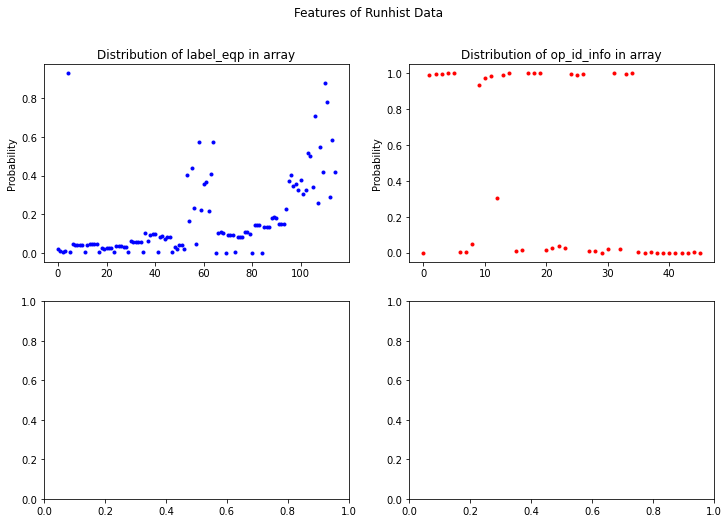

In [88]:
##### plot distribution of features #####
feature_distribution(runhist_all)

counts of equipment: 123 
counts of operation: 22 
counts of rework: 16


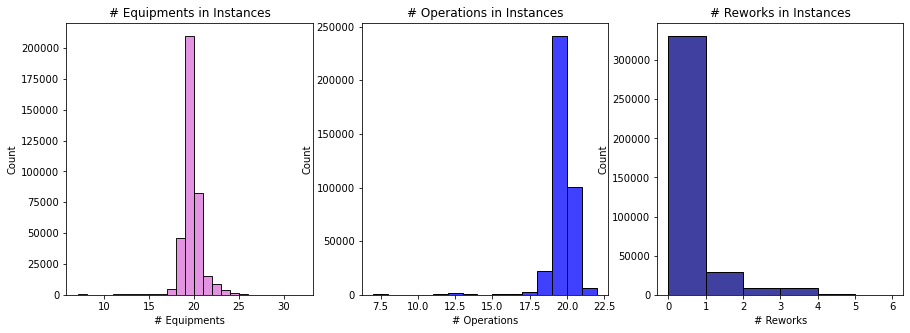

In [12]:
#### counts of equipment & operation used in each instances #####
category_distribution(runhist_all, bin1 = 25, bin2 = 15, bin3 = 6)   

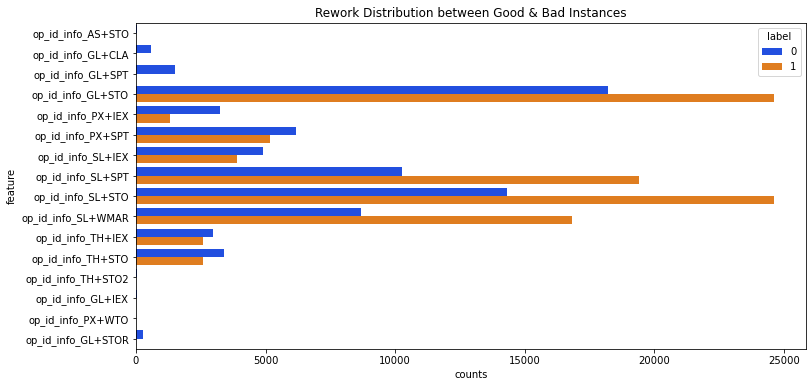

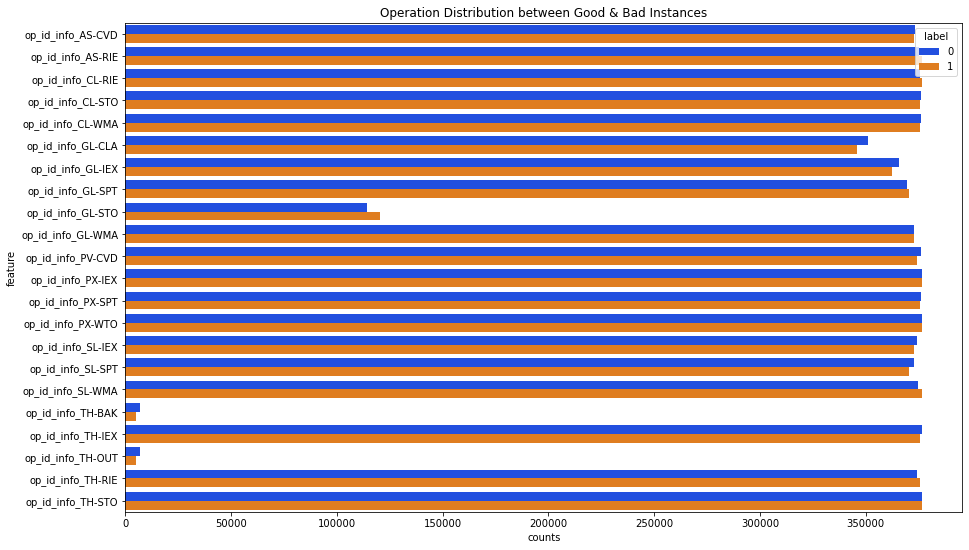

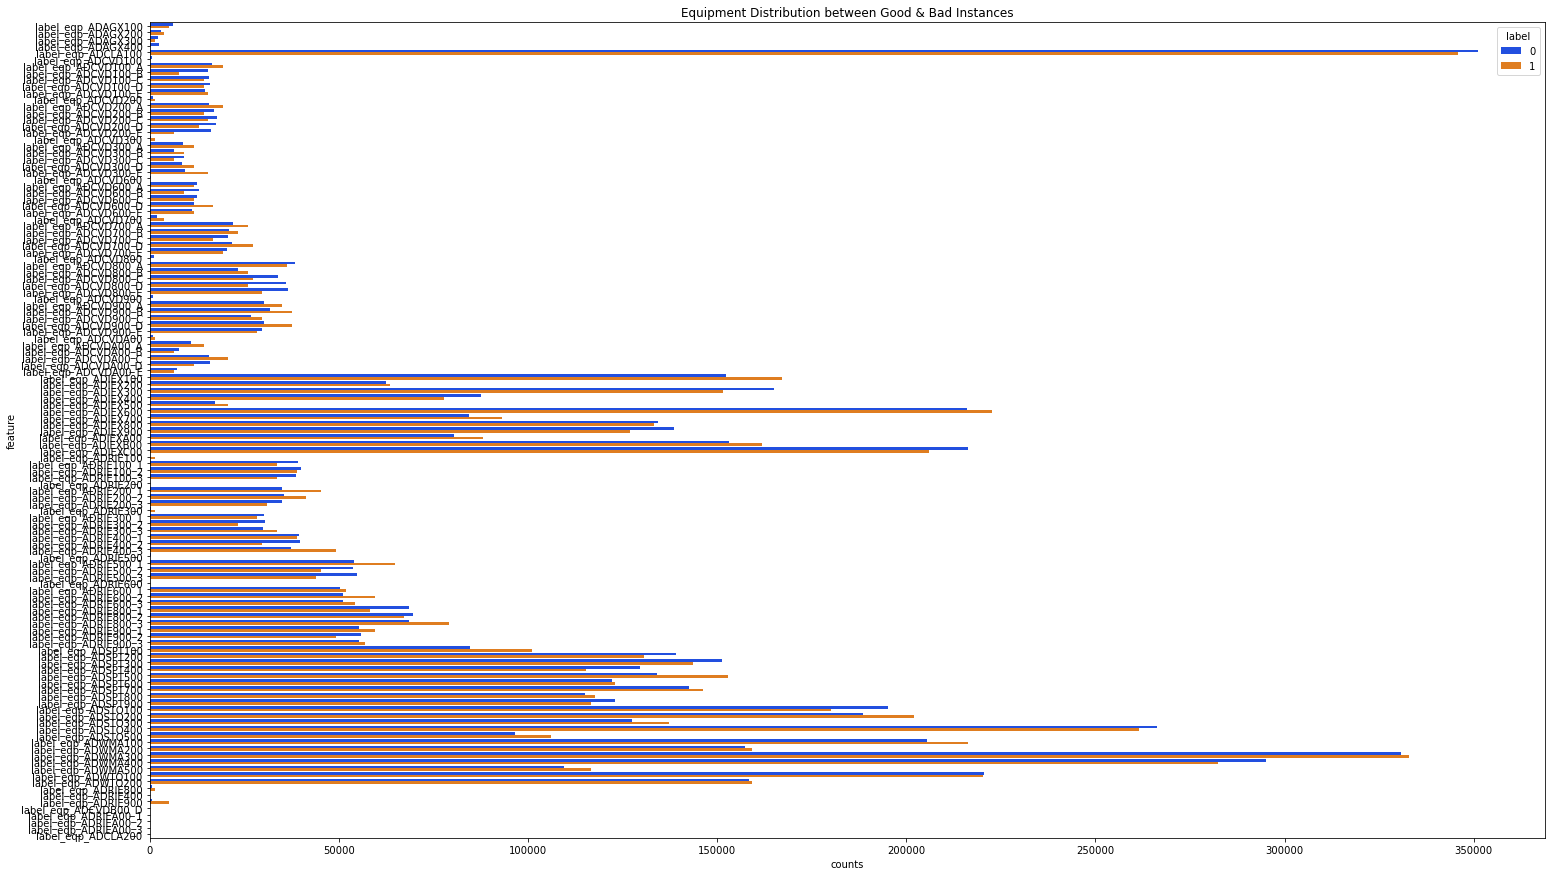

In [13]:
##### plot and compare the feature frequency (by category) in good & bad instances #####
array_target = runhist_all

bar_rework = feature_gb(array_target, target = 'Rework', figsize = (12, 6))
# bar_rework.set(xlim = (0, 250)) # zoom in to examine extremely low frequency rework 

bar_op = feature_gb(array_target, target = 'Operation', figsize = (15, 9))
# bar_op.set(xlim = (0, 2500)) 

bar_eqp = feature_gb(array_target, target = 'Equipment', figsize = (25, 15))

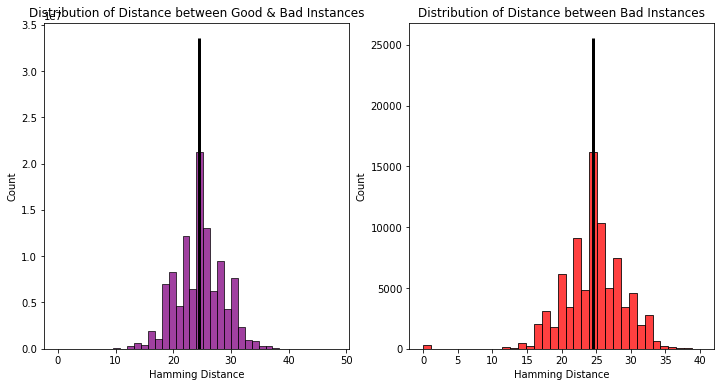

In [14]:
##### plot distance between instances #####
distance_histogram(runhist_all, bin1 = 40, bin2 = 35)

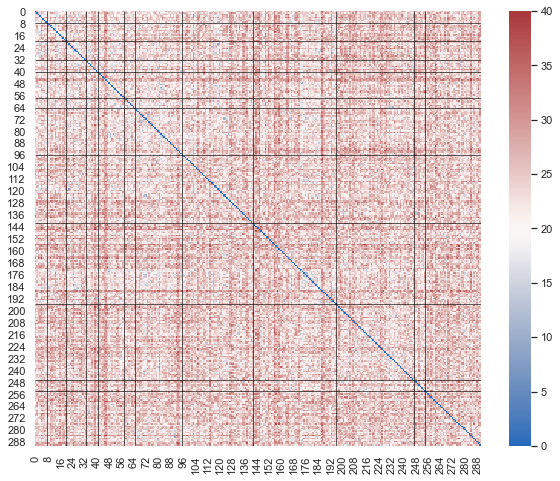

In [16]:
##### show the distance between bad instances by heatmap #####
bad_counts = [8, 12, 13, 8, 17, 7, 31, 46, 54, 51, 7, 37]
distance_heatmap(runhist_all, bad_counts)

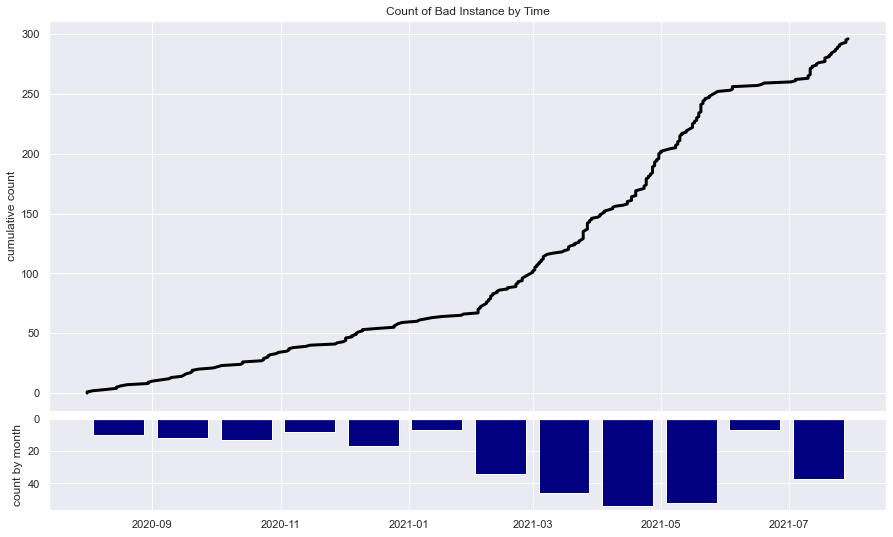

In [17]:
##### cumulative counts of bad instances by time #####
cumulative_bad(runhist_all, module_m8_m7)

C:\Users\user\anaconda3\envs\aging\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\user\anaconda3\envs\aging\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 't-SNE (month 2)')

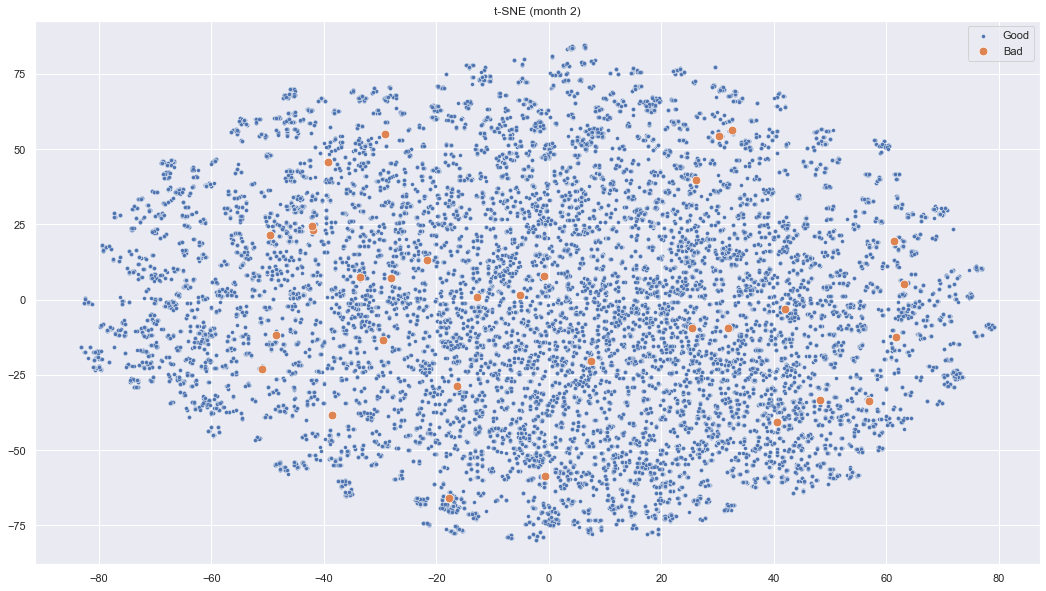

In [91]:
##### t-SNE (by month) #####
target_month = 2

tsne = TSNE(n_components = 2, n_jobs = -1, perplexity = 100)
embedded = tsne.fit_transform(array_done[f'm{target_month}'].iloc[:, 1:-1])
good_embed = embedded[(array_done[f'm{target_month}'].GB == 0), :]
bad_embed = embedded[(array_done[f'm{target_month}'].GB == 1), :]

sns.set(rc = {'figure.figsize':(18, 10)})
fig, ax = plt.subplots()
sns.scatterplot(good_embed[:, 0], good_embed[:, 1], s = 15, ax = ax, label = 'Good')
sns.scatterplot(bad_embed[:, 0], bad_embed[:, 1], s = 75, ax = ax, label = 'Bad')
ax.set_title(f't-SNE (month {target_month})')